<a href="https://colab.research.google.com/github/instrat-pl/pypsa-pl-mini/blob/main/notebooks/pypsa_pl_mini_capex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyPSA-PL-mini: CAPEX

Simplified energy modelling environment for rapid testing and education.

Example of joint OPEX and CAPEX optimisation.

Version 0.1

This notebook is released under [CC-BY-4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact person:** Patryk Kubiczek (patryk.kubiczek@instrat.pl)

## How to use it?

**Start by making your own copy of this notebook (File > Save a copy in Drive).** This notebook, containing an application of the the PyPSA-PL-mini model, is synchronised with the GitHub repository https://github.com/instrat-pl/pypsa-pl-mini. To play with the model, create your own copy of this notebook. 

[*General user*] 
Run the "Configuration" cells which will clone the PyPSA-PL-mini repository into your Google Colab space and which will install all the required libraries. This might take up to a few minutes. After the configuration is finished, you can proceed to experiment with PyPSA-PL-mini. Have fun!

## Configuration (run each cell just once)

In [1]:
import sys
import os

# Optionally install pl_PL.UTF-8 locale in Google Colab
# Source: https://stackoverflow.com/questions/67045349/change-locale-for-google-colab

skip_installing_pl_locale = True

if "google.colab" in sys.modules and not skip_installing_pl_locale:
  # Install pl_PL
  !/usr/share/locales/install-language-pack pl_PL.UTF-8
  !dpkg-reconfigure locales
    
  # Restart Python process to pick up the new locales
  os.kill(os.getpid(), 9)

In [2]:
import sys
import os
from pathlib import Path

instrat_user = False
force_installation = False

if "google.colab" in sys.modules:

  %cd "/content"

  if instrat_user:  
    
    from google.colab import drive
    root = "/content/drive"
    drive.mount(root)

    def project_dir(*path):
      return Path(root, "MyDrive", "Colab", "PyPSA-PL-mini", *path)

  else:
    
    from google.colab import userdata
    # ghtoken = userdata.get("GHTOKEN")

    !rm -rf pypsa-pl-mini
    # !git clone https://{ghtoken}@github.com/instrat-pl/pypsa-pl-mini.git
    !git clone https://github.com/instrat-pl/pypsa-pl-mini.git

    def project_dir(*path):
      return Path("/content", "pypsa-pl-mini", *path)

  %cd {str(project_dir())}

  if not instrat_user or force_installation:
    !pip install poetry --quiet
    !poetry config virtualenvs.in-project false
    !poetry config virtualenvs.path {str(project_dir("venv"))}
    !poetry install --no-ansi
    # ipywidgets have to be downgraded in Google Colab
    !poetry add ipywidgets@7.7.2 --no-ansi
      # Download and install Work Sans font
    !mkdir fonts
    !cd fonts  
    !wget https://github.com/weiweihuanghuang/Work-Sans/raw/master/fonts/ttf/WorkSans-Regular.ttf
    !wget https://github.com/weiweihuanghuang/Work-Sans/raw/master/fonts/ttf/WorkSans-Medium.ttf
    from matplotlib import font_manager
    font_files = ["WorkSans-Regular.ttf", "WorkSans-Medium.ttf"]
    for font_file in font_files:
        font_manager.fontManager.addfont(font_file)
    !cd ..

  v = f"{sys.version_info.major}.{sys.version_info.minor}"
  venv_location = !poetry env info -p
  VENV_PATH = os.path.join(venv_location[0], "lib", f"python{v}", "site-packages")
  sys.path.insert(0, VENV_PATH)  
  
  SRC_PATH = str(project_dir("src"))
  sys.path.insert(0, SRC_PATH)

else:
  %load_ext autoreload
  %autoreload 2

import pypsa_pl_mini.config

## Power system model

### Specify parameters

In [3]:
params = {
    # Run name and year
    "run_name": "pypsa_pl_mini_capex",
    "year": 2023,
    # Input data
    "technology_carrier_definitions": "mini",
    "technology_cost_data": "instrat_2024",
    "installed_capacity": "historical_totals",
    "annual_energy_flows": "historical",
    "capacity_utilisation": "historical",
    # Other assumptions
    "investment_technologies": [
        "wind onshore",
        "wind offshore",
        "solar PV ground",
        # "nuclear power large",
        "natural gas power CCGT",
        "natural gas power peaker",
        # "hard coal power SC",
        # "lignite power SC",
        "battery large power",
        "battery large charger",
        "battery large storage",
    ],
    "retirement_technologies": [
        # "hard coal power old",
        # "lignite power old",
        # "hard coal power SC",
        # "lignite power SC",
        # "biomass wood power",
    ],
    "constrained_energy_flows": [],
    "weather_year": 2012,
    "share_space_heating": 0.8,
    "prosumer_self_consumption": 0.2,
    "discount_rate": 0.03,
    "reoptimise_with_fixed_capacities": True, # if True, only OPEX determines marginal prices
    # Technical details
    "inf": 100000,
    "reverse_links": True,
    "solver": "highs",
}

### Prepare inputs


In [4]:
import numpy as np
from pypsa_pl_mini.build_network import load_and_preprocess_inputs


def custom_operation(inputs):

    def add_qualifier_to_technology(df, technology, qualifier):
        df.loc[df["technology"] == technology, "qualifier"] = qualifier
        return df

    # Identify solar PV roof as prosumer electricity source
    inputs["installed_capacity"] = add_qualifier_to_technology(
        inputs["installed_capacity"],  "solar PV roof", "prosumer",
    )
    

    def remove_capacities(df, technologies):
        df = df[~df["technology"].isin(technologies)]
        return df

    # Do not model cross border electricity flows in this simplified example
    inputs["installed_capacity"] = remove_capacities(
        inputs["installed_capacity"],
        technologies=[
            "electricity export AC",
            "electricity import AC",
            "electricity export DC",
            "electricity import DC",
        ],
    )

    def add_new_capacities(df, technologies):
        df = df.set_index("name")
        for technology in technologies:
            area = "PL"
            qualifier = np.nan
            build_year = params["year"]
            retire_year = np.nan
            cumulative = False
            nom = 0
            df.loc[f"PL {technology} new"] = [
                area,
                technology,
                qualifier,
                build_year,
                retire_year,
                cumulative,
                nom,
            ]
        df = df.reset_index()
        return df

    # Add candidate capacities to extend
    inputs["installed_capacity"] = add_new_capacities(
        inputs["installed_capacity"],
        technologies=[
            "wind onshore",
            "wind offshore",
            "solar PV ground",
            "nuclear power large",
            "natural gas power CCGT",
            "natural gas power peaker",
            "hard coal power SC",
            "lignite power SC",
            "battery large power",
            "battery large charger",
            "battery large storage",
        ],
    )

    def add_p_min_pu_constraint(df, technology, qualifier="", p_min_pu=0):
        df["qualifier"] = df["qualifier"].fillna("")
        df = df.set_index(["area", "technology", "qualifier", "year", "parameter"])
        df.loc[("PL", technology, qualifier, params["year"], "p_min_pu"), "value"] = (
            p_min_pu
        )
        df = df.reset_index()
        df["qualifier"] = df["qualifier"].replace("", np.nan)
        return df

    # Add 40% minimum load constraint for nuclear power plants
    inputs["capacity_utilisation"] = add_p_min_pu_constraint(
        inputs["capacity_utilisation"], "nuclear power large", p_min_pu=0.4
    )

    return inputs


inputs = load_and_preprocess_inputs(params, custom_operation=custom_operation)

2024-04-19 15:10:23 [INFO] NumExpr defaulting to 8 threads.


In [5]:
# name = "technology_carrier_definitions"
# name = "technology_cost_data"
name = "installed_capacity"
# name = "annual_energy_flows"
# name = "capacity_utilisation"
# name = "co2_cost"
# name = "final_use"

inputs[name]

,name,area,technology,qualifier,build_year,retire_year,cumulative,nom
0,PL battery large power 2021,PL,battery large power,NaN,2021,2021.0,True,50.0
1,PL battery large power 2022,PL,battery large power,NaN,2022,2022.0,True,100.0
2,PL battery large power 2023,PL,battery large power,NaN,2023,2023.0,True,150.0
3,PL battery large charger 2021,PL,battery large charger,NaN,2021,2021.0,True,50.0
4,PL battery large charger 2022,PL,battery large charger,NaN,2022,2022.0,True,90.0
...,...,...,...,...,...,...,...,...
138,PL hard coal power SC new,PL,hard coal power SC,NaN,2023,NaN,False,0.0
139,PL lignite power SC new,PL,lignite power SC,NaN,2023,NaN,False,0.0
140,PL battery large power new,PL,battery large power,NaN,2023,NaN,False,0.0
141,PL battery large charger new,PL,battery large charger,NaN,2023,NaN,False,0.0


### Create PyPSA network

In [6]:
from pypsa_pl_mini.build_network import create_custom_network

network = create_custom_network(params)

network

Empty PyPSA Network 'pypsa_pl_mini_capex'
Components: none
Snapshots: 1

### Add snapshots

In [7]:
from pypsa_pl_mini.build_network import add_snapshots

add_snapshots(network, params)

network.snapshots

Index(['2012-03-09 00:00:00', '2012-03-09 01:00:00', '2012-03-09 02:00:00',
       '2012-03-09 03:00:00', '2012-03-09 04:00:00', '2012-03-09 05:00:00',
       '2012-03-09 06:00:00', '2012-03-09 07:00:00', '2012-03-09 08:00:00',
       '2012-03-09 09:00:00',
       ...
       '2012-11-01 14:00:00', '2012-11-01 15:00:00', '2012-11-01 16:00:00',
       '2012-11-01 17:00:00', '2012-11-01 18:00:00', '2012-11-01 19:00:00',
       '2012-11-01 20:00:00', '2012-11-01 21:00:00', '2012-11-01 22:00:00',
       '2012-11-01 23:00:00'],
      dtype='object', name='snapshot', length=672)

### Add carriers

In [8]:
from pypsa_pl_mini.build_network import add_carriers

add_carriers(network, inputs, params)

network.carriers

,color,order,aggregation,co2_emissions,nice_name,max_growth,max_relative_growth
Carrier,,,,,,,
DSR reduction,#1b1c1e,191,DSR,NaN,,inf,0.0
battery large charger,#458aff,142,battery large,NaN,,inf,0.0
battery large power,#458aff,141,battery large,NaN,,inf,0.0
battery large storage,#458aff,140,battery large,NaN,,inf,0.0
biogas CHP,#816d66,82,biomass and biogas CHP,NaN,,inf,0.0
biogas production,#816d66,81,biomass and biogas supply,NaN,,inf,0.0
biogas substrate supply,#816d66,80,biomass and biogas supply,NaN,,inf,0.0
biomass agriculture CHP,#ab9d99,71,biomass and biogas CHP,NaN,,inf,0.0
biomass agriculture supply,#ab9d99,70,biomass and biogas supply,NaN,,inf,0.0


### Add buses

In [9]:
from pypsa_pl_mini.build_network import add_buses

add_buses(network, inputs, params)

network.buses

,area,carrier,v_nom,type,x,y,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,,
PL battery large electricity,PL,battery large electricity,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL biogas,PL,biogas,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL biogas substrate,PL,biogas substrate,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL biomass wood,PL,biomass wood,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL electricity,PL,electricity,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL hard coal,PL,hard coal,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL hydro PSH electricity,PL,hydro PSH electricity,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL lignite,PL,lignite,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL natural gas,PL,natural gas,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,


### Add generating, consuming, and storing capacity (generators, links, stores)

#### Process installed capacity data and specify the relevant attributes

In [10]:
from pypsa_pl_mini.build_network import process_capacity_data

df_cap = process_capacity_data(inputs, params)

df_cap.tail()

,name,area,technology,qualifier,build_year,retire_year,cumulative,nom,carrier,aggregation,...,p_nom_extendable,p_nom_min,p_nom_max,e_nom_extendable,e_nom_min,e_nom_max,p_set_annual,p_min_pu,p_max_pu,p_set
31,PL solar PV roof 2023,PL,solar PV roof,prosumer,2023,2023.0,True,10670.0,solar PV roof,solar PV roof,...,False,10670.0,10670.0,NaN,NaN,NaN,NaN,0.0,1.0,NaN
35,PL wind offshore new,PL,wind offshore,NaN,2023,2052.0,False,0.0,wind offshore,wind offshore,...,True,0.0,inf,NaN,NaN,NaN,NaN,0.0,1.0,NaN
32,PL wind onshore 2023,PL,wind onshore,NaN,2023,2023.0,True,3050.0,wind onshore,wind onshore,...,True,3050.0,3050.0,NaN,NaN,NaN,NaN,0.0,1.0,NaN
34,PL wind onshore new,PL,wind onshore,NaN,2023,2047.0,False,0.0,wind onshore,wind onshore,...,True,0.0,inf,NaN,NaN,NaN,NaN,0.0,1.0,NaN
33,PL wind onshore old 2023,PL,wind onshore old,NaN,2023,2023.0,True,6380.0,wind onshore,wind onshore,...,False,6380.0,6380.0,NaN,NaN,NaN,NaN,0.0,1.0,NaN


#### Specify which attributes are time dependent

In [11]:
from pypsa_pl_mini.define_time_dependent_attributes import (
    define_time_dependent_attributes,
)


df_attr_t = define_time_dependent_attributes(df_cap, params)

df_attr_t

,carrier,qualifier,attribute,profile_type
0,electricity final use,none,p_set,electricity final use load profile
1,biogas CHP,public,p_set,heat final use load profile
2,biomass wood CHP,public,p_set,heat final use load profile
3,hard coal CHP,public,p_set,heat final use load profile
4,natural gas CHP,public,p_set,heat final use load profile
5,solar PV ground,none,p_max_pu,vres availability profile
6,solar PV roof,prosumer,p_max_pu,vres availability profile
7,wind offshore,none,p_max_pu,vres availability profile
8,wind onshore,none,p_max_pu,vres availability profile
9,biogas CHP,industrial,p_set,constant load profile


#### Create actual components and fill them with data

In [12]:
from pypsa_pl_mini.build_network import add_capacities

add_capacities(network, df_cap, df_attr_t, params)

In [13]:
network.generators.tail()

,bus,area,carrier,technology,qualifier,aggregation,p_nom,p_nom_extendable,p_nom_min,p_nom_max,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
PL solar PV roof 2023,PL electricity,PL,solar PV roof,solar PV roof,prosumer,solar PV roof,10670.0,False,10670.0,10670.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
PL wind offshore new,PL electricity,PL,wind offshore,wind offshore,,wind offshore,0.0,True,0.0,inf,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
PL wind onshore 2023,PL electricity,PL,wind onshore,wind onshore,,wind onshore,3050.0,True,3050.0,3050.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
PL wind onshore new,PL electricity,PL,wind onshore,wind onshore,,wind onshore,0.0,True,0.0,inf,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
PL wind onshore old 2023,PL electricity,PL,wind onshore,wind onshore old,,wind onshore,6380.0,False,6380.0,6380.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


In [14]:
network.generators[["lifetime", "fixed_cost", "investment_cost", "annual_investment_cost", "capital_cost", "p_nom_extendable", "p_nom_min", "p_nom_max"]]

,lifetime,fixed_cost,investment_cost,annual_investment_cost,capital_cost,p_nom_extendable,p_nom_min,p_nom_max
Generator,,,,,,,,
PL biogas substrate supply 2023,1.0,0.0,0.0,0.000000e+00,0.000000e+00,False,100000.0,100000.0
PL biomass wood supply 2023,1.0,0.0,0.0,0.000000e+00,0.000000e+00,False,100000.0,100000.0
PL electricity final use 2023,1.0,0.0,0.0,0.000000e+00,0.000000e+00,False,100000.0,100000.0
PL hard coal supply 2023,1.0,0.0,0.0,0.000000e+00,0.000000e+00,False,100000.0,100000.0
PL hydro ROR 2023,1.0,0.0,0.0,0.000000e+00,0.000000e+00,False,600.0,600.0
PL lignite supply 2023,1.0,0.0,0.0,0.000000e+00,0.000000e+00,False,100000.0,100000.0
PL natural gas supply 2023,1.0,0.0,0.0,0.000000e+00,0.000000e+00,False,100000.0,100000.0
PL nuclear power large new,60.0,660000.0,33000000.0,1.192388e+06,1.852388e+06,False,0.0,0.0
PL other fuel supply 2023,1.0,0.0,0.0,0.000000e+00,0.000000e+00,False,100000.0,100000.0


In [15]:
network.links.tail()

,bus0,bus1,area,carrier,technology,qualifier,aggregation,p_nom,p_nom_extendable,p_nom_min,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Link,,,,,,,,,,,,,,,,,,,,,
PL natural gas CHP old industrial 2023,PL electricity,PL natural gas,PL,natural gas CHP,natural gas CHP old,industrial,natural gas CHP,1510.0,False,1510.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
PL natural gas CHP old public 2023,PL electricity,PL natural gas,PL,natural gas CHP,natural gas CHP old,public,natural gas CHP,2440.0,False,2440.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
PL natural gas power CCGT new,PL electricity,PL natural gas,PL,natural gas power,natural gas power CCGT,,natural gas power,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
PL natural gas power peaker new,PL electricity,PL natural gas,PL,natural gas power,natural gas power peaker,,natural gas power,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
PL other CHP industrial 2023,PL electricity,PL other fuel,PL,other CHP,other CHP,industrial,other CHP,550.0,False,550.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


In [16]:
network.links[["lifetime", "fixed_cost", "investment_cost", "annual_investment_cost", "capital_cost", "p_nom_extendable", "p_nom_min", "p_nom_max"]]

,lifetime,fixed_cost,investment_cost,annual_investment_cost,capital_cost,p_nom_extendable,p_nom_min,p_nom_max
Link,,,,,,,,
PL battery large charger 2023,1.0,0.0,0.0,0.000000,0.000000,True,140.0,140.0
PL battery large charger new,20.0,0.0,0.0,0.000000,0.000000,True,0.0,inf
PL battery large power 2023,1.0,3400.0,0.0,0.000000,3400.000000,True,150.0,150.0
PL battery large power new,20.0,3400.0,1700000.0,114266.702915,117666.702915,True,0.0,inf
PL biogas CHP industrial 2023,1.0,62000.0,0.0,0.000000,62000.000000,False,70.0,70.0
PL biogas CHP public 2023,1.0,62000.0,0.0,0.000000,62000.000000,False,210.0,210.0
PL biogas production industrial 2023,1.0,350000.0,0.0,0.000000,350000.000000,False,180.0,180.0
PL biogas production public 2023,1.0,350000.0,0.0,0.000000,350000.000000,False,520.0,520.0
PL biomass wood CHP industrial 2023,1.0,940000.0,0.0,0.000000,940000.000000,False,200.0,200.0


In [17]:
network.stores.tail()

,bus,area,carrier,technology,qualifier,aggregation,e_nom,e_nom_extendable,e_nom_min,e_nom_max,...,e_max_pu,e_initial,e_initial_per_period,e_cyclic_per_period,p_set,q_set,sign,marginal_cost_quadratic,standing_loss,e_nom_opt
Store,,,,,,,,,,,,,,,,,,,,,
PL battery large storage 2023,PL battery large electricity,PL,battery large storage,battery large storage,,battery large,600.0,True,600.0,600.0,...,1.0,0.0,False,True,0.0,0.0,1.0,0.0,0.0,0.0
PL battery large storage new,PL battery large electricity,PL,battery large storage,battery large storage,,battery large,0.0,True,0.0,inf,...,1.0,0.0,False,True,0.0,0.0,1.0,0.0,0.0,0.0
PL hydro PSH storage 2023,PL hydro PSH electricity,PL,hydro PSH storage,hydro PSH storage,,hydro PSH,8470.0,False,8470.0,8470.0,...,1.0,0.0,False,True,0.0,0.0,1.0,0.0,0.0,0.0


In [18]:
network.stores[["lifetime", "fixed_cost", "investment_cost", "annual_investment_cost", "capital_cost", "e_nom_extendable", "e_nom_min", "e_nom_max"]]

,lifetime,fixed_cost,investment_cost,annual_investment_cost,capital_cost,e_nom_extendable,e_nom_min,e_nom_max
Store,,,,,,,,
PL battery large storage 2023,1.0,0.0,0.0,0.000000,0.000000,True,600.0,600.0
PL battery large storage new,20.0,0.0,1500000.0,100823.561395,100823.561395,True,0.0,inf
PL hydro PSH storage 2023,1.0,0.0,0.0,0.000000,0.000000,False,8470.0,8470.0


### Add flow constraints

In [19]:
from pypsa_pl_mini.build_network import add_energy_flow_constraints

add_energy_flow_constraints(network, inputs, params)

# No flow constraints are added by default
network.global_constraints

,type,investment_period,carrier_attribute,sense,constant,mu
GlobalConstraint,,,,,,


### Save input network

In [20]:
from pypsa_pl_mini.config import data_dir

os.makedirs(data_dir("runs", params["run_name"]), exist_ok=True)
network.export_to_csv_folder(data_dir("runs", params["run_name"], "input_network"))

2024-04-19 15:10:37 [INFO] Exported network input_network has links, buses, stores, generators, carriers


### Solve the model

In [21]:
from pypsa_pl_mini.optimise_network import optimise_network

optimise_network(network, params)

2024-04-19 15:10:43 [INFO]  Solve problem using Highs solver
2024-04-19 15:10:44 [INFO] Solver options:
 - threads: 4
 - solver: ipm
 - run_crossover: off
 - small_matrix_value: 1e-07
 - large_matrix_value: 1000000000000.0
 - primal_feasibility_tolerance: 1e-06
 - dual_feasibility_tolerance: 1e-06
 - ipm_optimality_tolerance: 1e-07
 - parallel: on
 - random_seed: 0
2024-04-19 15:10:44 [INFO] Writing objective.
Writing continuous variables.: 100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 17.40it/s]
2024-04-19 15:10:48 [INFO]  Writing time: 3.26s
2024-04-19 15:10:49 [INFO] Log file at /tmp/highs.log.


Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
9756 rows, 17211 cols, 36716 nonzeros
9756 rows, 16847 cols, 36352 nonzeros
Presolve : Reductions: rows 9756(-67543); columns 16847(-15423); elements 36352(-94076)
Solving the presolved LP
IPX model has 9756 rows, 16847 columns and 36352 nonzeros
Input
    Number of variables:                                16847
    Number of free variables:                           2016
    Number of constraints:                              9756
    Number of equality constraints:                     4704
    Number of matrix entries:                           36352
    Matrix range:                                       [4e-04, 2e+00]
    RHS range:                                          [2e+03, 2e+04]
    Objective range:                                    [1e+02, 1e+06]
    Bounds range:                                       [1e+01, 1e+05]
Preprocessing
    Dualiz

2024-04-19 15:10:52 [INFO]  Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 32270 primals, 77299 duals
Objective: 7.50e+10
Solver model: available
Solver message: optimal

2024-04-19 15:10:53 [INFO] The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper, Link-p_set, Store-fix-e-lower, Store-fix-e-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.
2024-04-19 15:10:53 [INFO] Repeating optimization with optimal capacities fixed...
2024-04-19 15:10:57 [INFO]  Solve problem using Highs solver
2024-04-19 15:10:57 [INFO] Solver options:
 - threads: 4
 - solver: ipm
 - run_crossover: off
 - small_matrix_value: 1e-07
 - large_matrix_value: 1000000000000.0
 - primal_feasibility_tolerance: 1e-06
 - dual_feasibility_tolerance: 1e-06
 - ipm_optimality_tolerance:

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
3360 rows, 11673 cols, 17049 nonzeros
3313 rows, 9975 cols, 15163 nonzeros
Presolve : Reductions: rows 3313(-73967); columns 9975(-22281); elements 15163(-107141)
Solving the presolved LP
IPX model has 3313 rows, 9975 columns and 15163 nonzeros
Input
    Number of variables:                                9975
    Number of free variables:                           1344
    Number of constraints:                              3313
    Number of equality constraints:                     3313
    Number of matrix entries:                           15163
    Matrix range:                                       [1e+00, 1e+00]
    RHS range:                                          [5e+02, 2e+04]
    Objective range:                                    [4e+01, 1e+04]
    Bounds range:                                       [2e+01, 1e+04]
Preprocessing
    Dualized 

2024-04-19 15:11:02 [INFO]  Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 32256 primals, 77280 duals
Objective: 7.02e+10
Solver model: available
Solver message: optimal

2024-04-19 15:11:03 [INFO] The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, Link-p_set, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.


### Save output network

In [22]:
network.export_to_csv_folder(data_dir("runs", params["run_name"], "output_network"))

2024-04-19 15:11:03 [INFO] Exported network output_network has links, buses, stores, generators, carriers


### Analyse results

In [23]:
import pandas as pd


def append_annual_sum(df, value_cols=["value"]):
    agg = "carrier" if "carrier" in df.columns else "aggregation"
    return pd.concat(
        [
            df,
            df.groupby("year")
            .agg({agg: lambda x: "SUM", **{col: "sum" for col in value_cols}})
            .reset_index(),
        ]
    )

#### Display statistics

In [24]:
from pypsa_pl_mini.process_output_network import calculate_statistics

df_stat = calculate_statistics(network)
df_stat

,year,component,area,aggregation,carrier,technology,qualifier,Optimal Capacity,Installed Capacity,Capacity Factor,Dispatch,Transmission,Withdrawal,Supply,Curtailment,Capital Expenditure,Operational Expenditure,Revenue,Market Value
0,2023,Generator,PL,biomass and biogas supply,biogas substrate supply,biogas substrate supply,,100000.000000,100000.0000,0.004009,3.511554e+06,0.0,0.000000e+00,3.511554e+06,0.000000e+00,0.000000e+00,6.320797e+08,6.320797e+08,180.000000
1,2023,Generator,PL,biomass and biogas supply,biomass wood supply,biomass wood supply,,100000.000000,100000.0000,0.018563,1.626095e+07,0.0,0.000000e+00,1.626095e+07,0.000000e+00,0.000000e+00,1.951314e+09,1.951314e+09,120.000000
2,2023,Generator,PL,electricity final use,electricity final use,electricity final use,,100000.000000,100000.0000,0.176138,-1.542970e+08,0.0,1.542970e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.064137e+10,NaN
3,2023,Generator,PL,hard coal supply,hard coal supply,hard coal supply,,100000.000000,100000.0000,0.176527,1.546379e+08,0.0,0.000000e+00,1.546379e+08,0.000000e+00,0.000000e+00,3.853578e+10,3.853578e+10,249.200000
4,2023,Generator,PL,hydro ROR,hydro ROR,hydro ROR,,600.000000,600.0000,0.460000,2.417760e+06,0.0,0.000000e+00,2.417760e+06,0.000000e+00,0.000000e+00,0.000000e+00,7.811153e+08,323.073975
5,2023,Generator,PL,lignite supply,lignite supply,lignite supply,,100000.000000,100000.0000,0.094245,8.255850e+07,0.0,0.000000e+00,8.255850e+07,0.000000e+00,0.000000e+00,1.535588e+10,1.535588e+10,186.000000
6,2023,Generator,PL,natural gas supply,natural gas supply,natural gas supply,,100000.000000,100000.0000,0.037200,3.258707e+07,0.0,0.000000e+00,3.258707e+07,0.000000e+00,0.000000e+00,9.319902e+09,9.319902e+09,286.000000
7,2023,Generator,PL,nuclear power,nuclear power,nuclear power large,,0.000000,0.0000,NaN,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
8,2023,Generator,PL,other fuel supply,other fuel supply,other fuel supply,,100000.000000,100000.0000,0.008088,7.085294e+06,0.0,0.000000e+00,7.085294e+06,0.000000e+00,0.000000e+00,1.499248e+09,1.499248e+09,211.600000
9,2023,Generator,PL,solar PV ground,solar PV ground,solar PV ground,,7942.825901,6380.0638,0.116932,8.136054e+06,0.0,0.000000e+00,8.136054e+06,2.134445e+05,7.250747e+08,0.000000e+00,1.932108e+09,237.474829


In [25]:
# Example of statistics use: curtailed vRES energy ratio
df = df_stat.groupby("carrier")[["Supply", "Curtailment"]].sum()
df = 1 / (1 + df["Supply"] / df["Curtailment"])
df = df[df > 0].round(3).rename("value").to_frame()
df

,value
carrier,
solar PV ground,0.026
solar PV roof,0.000
wind onshore,0.291


#### Plot electrical capacity mix

,year,carrier,value
0,2023,battery large power,0.15
1,2023,biogas CHP,0.28
2,2023,biomass wood CHP,0.46
3,2023,biomass wood power,0.40
4,2023,hard coal CHP,5.15
5,2023,hard coal power,15.35
6,2023,hydro PSH power,1.79
7,2023,hydro ROR,0.60
8,2023,lignite power,7.64
9,2023,natural gas CHP,3.95


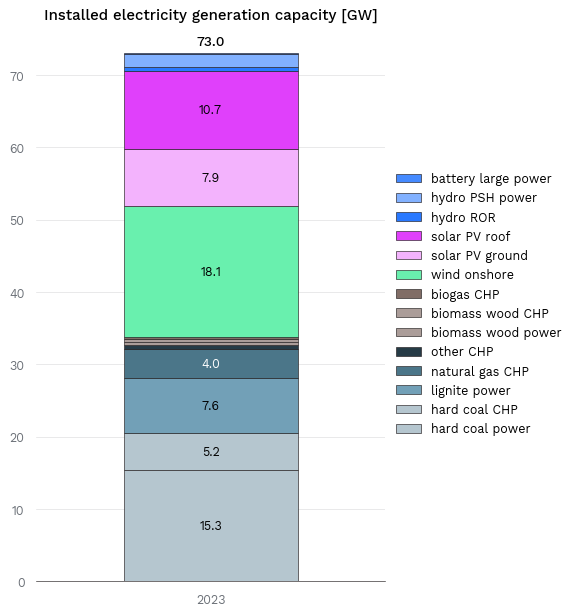

In [26]:
from pypsa_pl_mini.plot_outputs import plot_installed_capacities

fig, df = plot_installed_capacities(network)

df = append_annual_sum(df)
df

,year,carrier,value
0,2023,battery large power,0.00
1,2023,biogas CHP,0.00
2,2023,biomass wood CHP,0.00
3,2023,biomass wood power,0.00
4,2023,hard coal CHP,0.00
5,2023,hard coal power,0.00
6,2023,hydro PSH power,0.00
7,2023,hydro ROR,0.00
8,2023,lignite power,0.00
9,2023,natural gas CHP,0.00


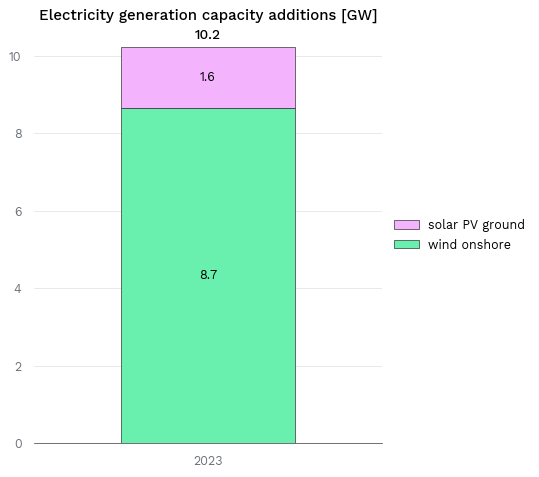

In [27]:
from pypsa_pl_mini.plot_outputs import plot_capacity_additions

fig, df = plot_capacity_additions(network)

df = append_annual_sum(df)
df

,year,carrier,value
0,2023,battery large storage,0.60
1,2023,hydro PSH storage,8.47
0,2023,SUM,9.07


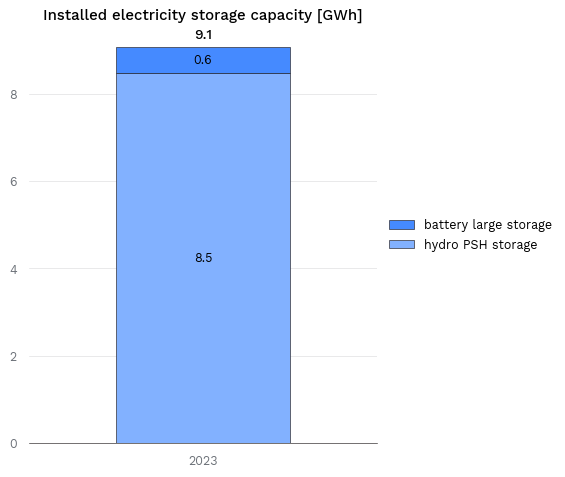

In [28]:
from pypsa_pl_mini.plot_outputs import plot_storage_capacities, plot_storage_capacity_additions

fig, df = plot_storage_capacities(network)

df = append_annual_sum(df)
df

#### Plot electricity generation mix

,year,carrier,value
0,2023,battery large charger,-0.25
1,2023,battery large power,0.22
2,2023,biogas CHP,1.30
3,2023,biomass wood CHP,2.34
4,2023,biomass wood power,2.32
6,2023,hard coal CHP,15.61
7,2023,hard coal power,34.13
8,2023,hydro PSH power,1.48
9,2023,hydro PSH pump,-2.11
10,2023,hydro ROR,2.42


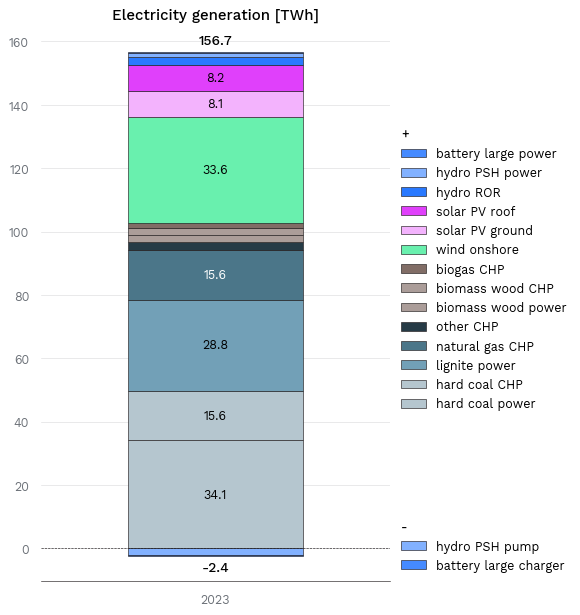

In [29]:
from pypsa_pl_mini.plot_outputs import plot_annual_generation

fig, df = plot_annual_generation(network)

df = append_annual_sum(df)
df

#### Plot fuel consumption and CO2 emissions

,year,carrier,value
1,2023,biogas substrate supply,12.6
4,2023,biomass wood supply,58.5
7,2023,hard coal supply,556.7
9,2023,lignite supply,297.2
12,2023,natural gas supply,117.3
14,2023,other fuel supply,25.5
0,2023,SUM,1067.8


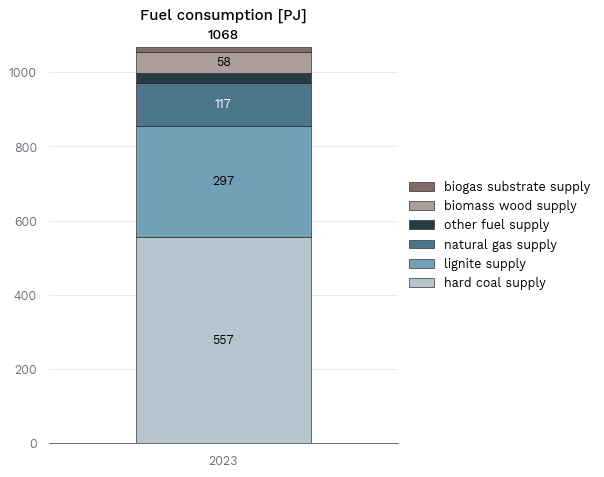

In [30]:
from pypsa_pl_mini.plot_outputs import plot_fuel_consumption

fig, df = plot_fuel_consumption(network)

df = append_annual_sum(df)
df

,year,carrier,value
7,2023,hard coal supply,52.58
9,2023,lignite supply,33.02
12,2023,natural gas supply,6.52
14,2023,other fuel supply,2.27
0,2023,SUM,94.39


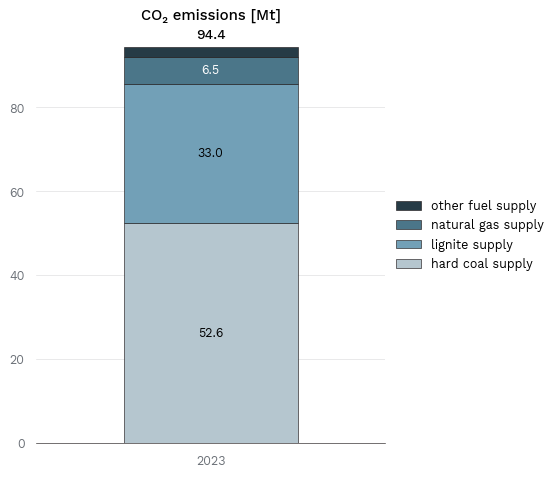

In [31]:
from pypsa_pl_mini.plot_outputs import plot_co2_emissions

fig, df = plot_co2_emissions(network)

df = append_annual_sum(df)
df

#### Plot hourly electricity generation

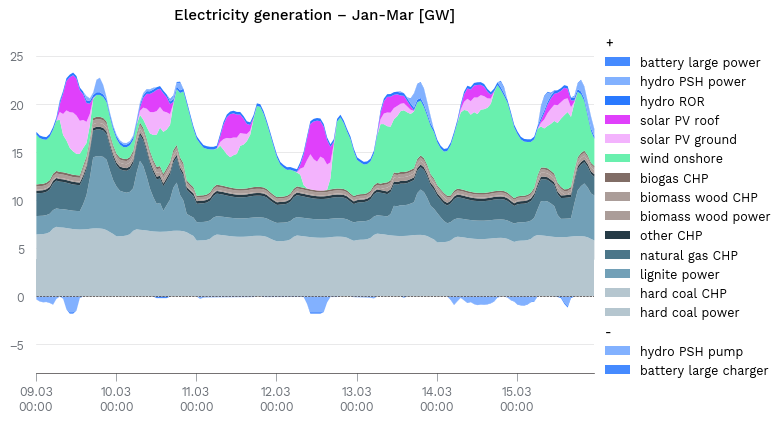

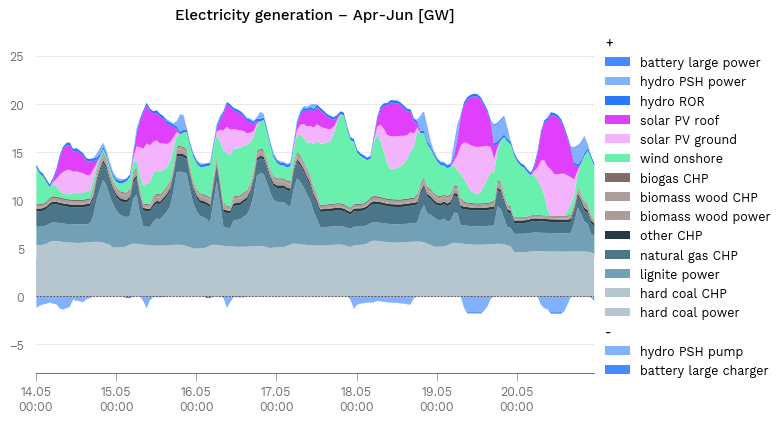

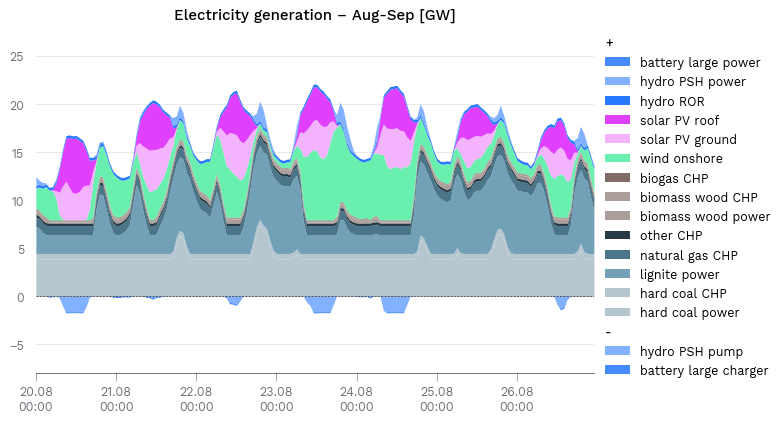

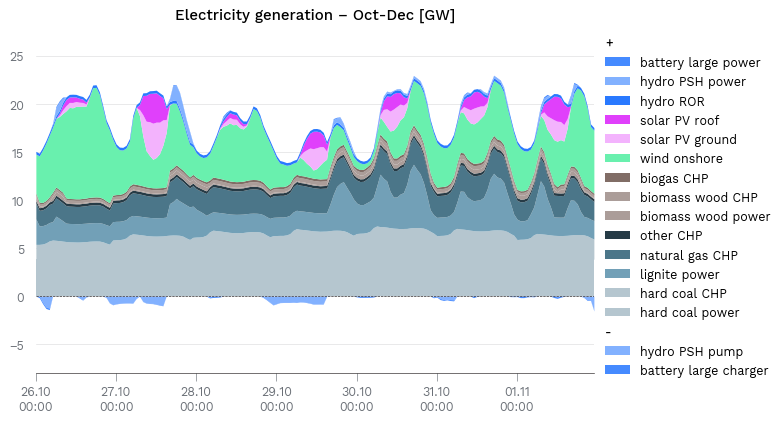

In [32]:
from pypsa_pl_mini.plot_outputs import plot_hourly_generation

n_per_subperiod = 7 * 24
subperiods = [
    (subperiod, (i * n_per_subperiod, (i + 1) * n_per_subperiod))
    for i, subperiod in enumerate(["Jan-Mar", "Apr-Jun", "Aug-Sep", "Oct-Dec"])
]

fig, df = plot_hourly_generation(network, subperiods=subperiods, ylim=(-8, 28))

In [33]:
df

carrier,battery large charger,battery large power,biogas CHP,biomass wood CHP,biomass wood power,hard coal CHP,hard coal power,hydro PSH power,hydro PSH pump,hydro ROR,lignite power,natural gas CHP,natural gas power,nuclear power,other CHP,solar PV ground,solar PV roof,wind offshore,wind onshore
2012-03-09 00:00:00,-0.030,0.0,0.214,0.346,0.1,2.620,3.838,0.0,-0.262,0.276,1.910,2.351,0.0,0.0,0.275,0.0,0.0,0.0,5.185
2012-03-09 01:00:00,-0.030,0.0,0.216,0.348,0.1,2.642,3.838,0.0,-0.473,0.276,1.910,2.366,0.0,0.0,0.275,0.0,0.0,0.0,4.774
2012-03-09 02:00:00,-0.030,0.0,0.217,0.349,0.1,2.658,3.838,0.0,-0.558,0.276,1.910,2.376,0.0,0.0,0.275,0.0,0.0,0.0,4.618
2012-03-09 03:00:00,-0.029,0.0,0.222,0.355,0.1,2.722,3.838,0.0,-0.533,0.276,1.910,2.419,0.0,0.0,0.275,0.0,0.0,0.0,4.456
2012-03-09 04:00:00,-0.029,0.0,0.233,0.368,0.1,2.864,3.838,0.0,-0.636,0.276,1.910,2.515,0.0,0.0,0.275,0.0,0.0,0.0,4.525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-01 19:00:00,0.000,0.0,0.210,0.340,0.4,2.559,3.838,0.0,0.000,0.276,2.397,2.310,0.0,0.0,0.275,0.0,0.0,0.0,9.079
2012-11-01 20:00:00,-0.041,0.0,0.207,0.337,0.1,2.526,3.838,0.0,-0.101,0.276,1.910,2.287,0.0,0.0,0.275,0.0,0.0,0.0,9.312
2012-11-01 21:00:00,-0.066,0.0,0.200,0.328,0.1,2.433,3.838,0.0,-0.376,0.276,1.910,2.225,0.0,0.0,0.275,0.0,0.0,0.0,8.197
2012-11-01 22:00:00,-0.037,0.0,0.186,0.311,0.1,2.251,3.838,0.0,-0.418,0.276,1.910,2.102,0.0,0.0,0.275,0.0,0.0,0.0,6.645


#### Plot marginal cost of electricity production

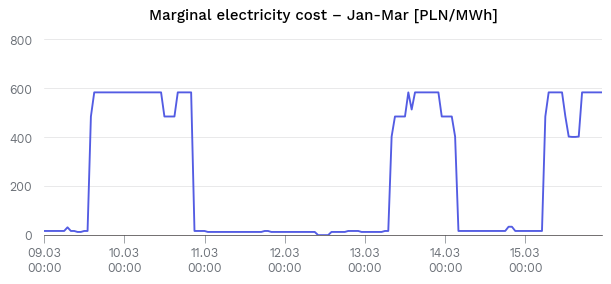

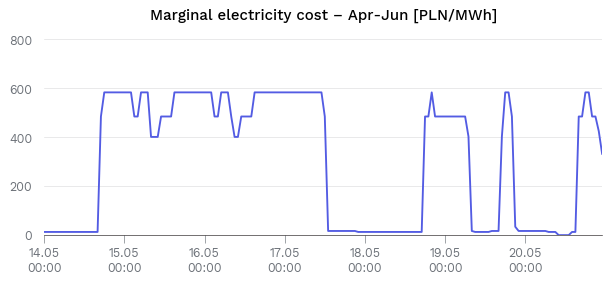

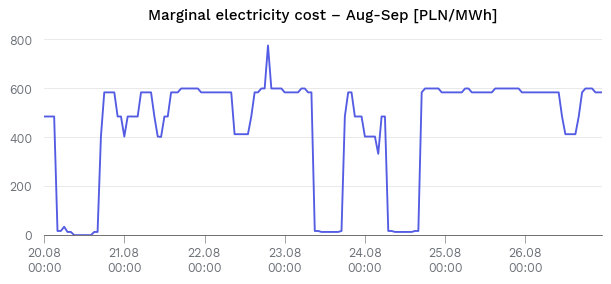

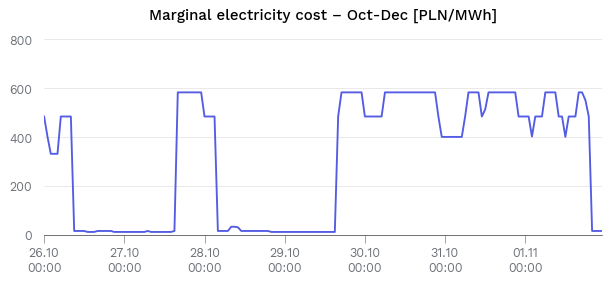

In [34]:
from pypsa_pl_mini.plot_outputs import plot_prices

n_per_subperiod = 7 * 24
subperiods = [
    (subperiod, (i * n_per_subperiod, (i + 1) * n_per_subperiod))
    for i, subperiod in enumerate(["Jan-Mar", "Apr-Jun", "Aug-Sep", "Oct-Dec"])
]

fig, df = plot_prices(network, subperiods=subperiods, ylim=(0, 850))

df_price = df.copy()

Avg. electricity price (simple): 323.1 PLN/MWh


,metric,value
0,Avg. unit cost,554.2
1,Avg. price,328.2


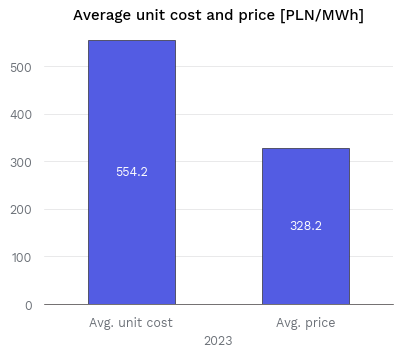

In [35]:
from pypsa_pl_mini.plot_outputs import plot_average_unit_cost_and_price

fig, df = plot_average_unit_cost_and_price(network)

# Calculate simple (i.e. non-weighted) avg. market price
mean_price = df_price.mean().values[0].round(1)
print("Avg. electricity price (simple):", mean_price, "PLN/MWh")

df

#### Plot total overnight investment costs

,year,aggregation,value
17,2023,solar PV ground,5.16
20,2023,wind onshore,61.45
0,2023,SUM,66.61


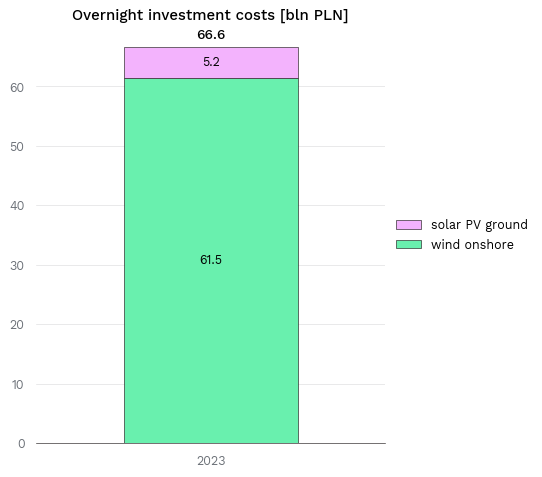

In [36]:
from pypsa_pl_mini.plot_outputs import plot_capex

fig, df = plot_capex(network, "investment_cost")

df = append_annual_sum(df)

df

#### Plot total annual costs

,year,aggregation,value
1,2023,biomass and biogas CHP,0.58
2,2023,biomass and biogas supply,2.84
3,2023,biomass power,0.31
5,2023,hard coal power,5.30
6,2023,hard coal supply,38.54
7,2023,hydro PSH,0.11
9,2023,lignite power,2.18
10,2023,lignite supply,15.36
11,2023,natural gas CHP,1.19
13,2023,natural gas supply,9.32


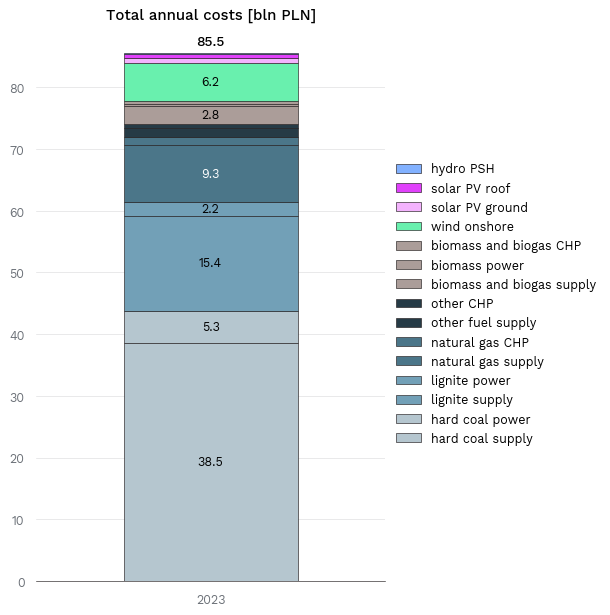

In [37]:
from pypsa_pl_mini.plot_outputs import plot_total_costs

fig, df = plot_total_costs(network, costs=["OPEX", "CAPEX"])

df = append_annual_sum(df)

df

#### Plot annual cost structure

cost component,year,aggregation,Var. O&M,CO₂,Fix. O&M,Ann. invest.,SUM
0,2023,biomass and biogas CHP,0.13,0.00,0.45,0.00,0.58
1,2023,biomass and biogas supply,2.59,0.00,0.24,0.00,2.83
2,2023,biomass power,0.07,0.00,0.24,0.00,0.31
3,2023,hard coal power,0.99,0.00,4.30,0.00,5.29
4,2023,hard coal supply,18.56,19.98,0.00,0.00,38.54
5,2023,hydro PSH,0.01,0.00,0.09,0.00,0.10
6,2023,lignite power,0.58,0.00,1.60,0.00,2.18
7,2023,lignite supply,2.81,12.55,0.00,0.00,15.36
8,2023,natural gas CHP,0.44,0.00,0.75,0.00,1.19
9,2023,natural gas supply,6.84,2.48,0.00,0.00,9.32


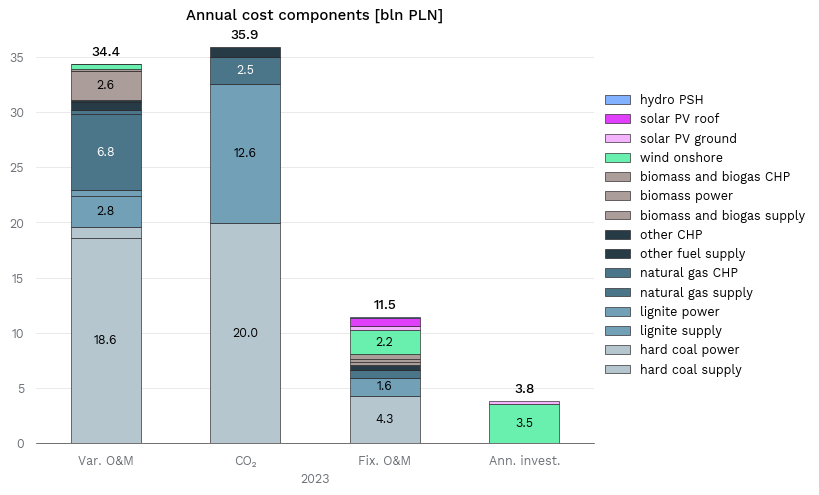

In [38]:
from pypsa_pl_mini.plot_outputs import plot_detailed_costs

fig, df = plot_detailed_costs(network)

df = df.pivot(index="aggregation", columns="cost component", values="value").fillna(0)
columns = list(df.columns)

# The sum of OPEX and CAPEX is the objective function's value

df["SUM"] = df.sum(axis=1)
df = df.reset_index().assign(year=params["year"])
df = append_annual_sum(df, value_cols=columns+["SUM"])
df = df.set_index(["year", "aggregation"]).reset_index()

df

### Sensitivity analysis: cost assumptions

In [39]:
import logging
import numpy as np
from matplotlib import pyplot as plt
from io import BytesIO
import ipywidgets as widgets
from ipywidgets import interact_manual

from pypsa_pl_mini.helper_functions import suppress_stdout
from pypsa_pl_mini.mathematical_operations import calculate_annuity

In [40]:
default_p_min_pu = 0.25

def update_p_min_pu_of_public_power_plants(network, p_min_pu=default_p_min_pu):
    is_public_pp = network.links["carrier"].isin(
        ["hard coal power", "lignite power", "biomass wood power"]
    ) & (network.links["qualifier"] == "public")
    if network.meta["reverse_links"]:
        network.links.loc[is_public_pp, "p_max_pu"] = -p_min_pu
    else:
        network.links.loc[is_public_pp, "p_min_pu"] = p_min_pu
    return network

In [41]:
eur_to_pln = 4.54  # 2023 exchange rate
default_co2_price = 83  # in EUR/tCO2

def update_co2_costs(network, co2_price=default_co2_price):
    co2_price_pln = round(co2_price * eur_to_pln, -1)
    logging.info(f"Setting CO2 price to {co2_price_pln} PLN/tCO2")

    fossil_carriers = [
        "hard coal supply",
        "lignite supply",
        "natural gas supply",
        "other fuel supply",
    ]
    is_fossil_supply = network.generators["carrier"].isin(fossil_carriers)
    co2_cost = (
        network.carriers.loc[fossil_carriers, "co2_emissions"] * co2_price_pln
    ).rename("co2_cost")
    co2_cost = pd.merge(
        network.generators.loc[is_fossil_supply, "carrier"],
        co2_cost,
        left_on="carrier",
        right_index=True,
        how="left",
    )["co2_cost"]

    network.generators.loc[is_fossil_supply, "co2_cost"] = co2_cost
    network.generators["marginal_cost"] = (
        network.generators["co2_cost"] + network.generators["variable_cost"]
    )

In [42]:
for component in ["Generator", "Link", "Store"]:
    network.df(component)["default_investment_cost"] = network.df(component)[
        "investment_cost"
    ]

default_discount_rate = params["discount_rate"]


def update_investment_costs(
    network,
    wind_solar_cost_factor=1,
    battery_cost_factor=1,
    nuclear_cost_factor=1,
):
    is_wind_or_solar = network.generators["carrier"].str.startswith(
        ("wind", "solar PV")
    )
    network.generators.loc[is_wind_or_solar, "investment_cost"] = (
        wind_solar_cost_factor
        * network.generators.loc[is_wind_or_solar, "default_investment_cost"]
    )
    is_battery_link = network.links["carrier"].str.startswith("battery")
    network.links.loc[is_battery_link, "investment_cost"] = (
        battery_cost_factor
        * network.links.loc[is_battery_link, "default_investment_cost"]
    )
    is_battery_store = network.stores["carrier"].str.startswith("battery")
    network.stores.loc[is_battery_store, "investment_cost"] = (
        battery_cost_factor
        * network.stores.loc[is_battery_store, "default_investment_cost"]
    )
    is_nuclear = network.generators["carrier"].str.startswith("nuclear")
    network.generators.loc[is_nuclear, "investment_cost"] = (
        nuclear_cost_factor
        * network.generators.loc[is_nuclear, "default_investment_cost"]
    )


def update_discount_rate(network, params, discount_rate=default_discount_rate):
    params["discount_rate"] = discount_rate
    for component in ["Generator", "Link", "Store"]:
        has_investment_cost = network.df(component)["lifetime"] > 1
        network.df(component).loc[
            has_investment_cost, "annual_investment_cost"
        ] = network.df(component).loc[
            has_investment_cost, "investment_cost"
        ] * calculate_annuity(
            lifetime=network.df(component).loc[has_investment_cost, "lifetime"],
            discount_rate=discount_rate,
        )
        network.generators["capital_cost"] = (
            network.generators["fixed_cost"]
            + network.generators["annual_investment_cost"]
        )

In [43]:
default_investment_technologies = [
    tech for tech in params["investment_technologies"] 
    if tech not in ["battery large power", "battery large charger", "battery large storage"]
] + ["battery large"]
default_retirement_technologies = params["retirement_technologies"]


def update_extendability(
    network,
    params,
    investment_technologies=default_investment_technologies, 
    retirement_technologies=default_retirement_technologies,
):

    if "battery large" in investment_technologies:
        investment_technologies = investment_technologies + [
            "battery large power", "battery large charger", "battery large storage"
        ]

    params["investment_technologies"] = investment_technologies
    params["retirement_technologies"] = retirement_technologies

    for component, nom_attr in [
        ("Generator", "p_nom"),
        ("Link", "p_nom"),
        ("Store", "e_nom"),
    ]:
        is_to_invest = network.df(component)["technology"].isin(investment_technologies)
        is_to_retire = network.df(component)["technology"].isin(retirement_technologies)
        network.df(component)[f"{nom_attr}_extendable"] = is_to_invest | is_to_retire

        network.df(component)[f"{nom_attr}_min"] = network.df(component)[nom_attr]
        network.df(component)[f"{nom_attr}_max"] = network.df(component)[nom_attr]

        is_cumulative = network.df(component)["lifetime"] == 1
        is_active = network.df(component)["build_year"] == network.meta["year"]

        network.df(component).loc[
            is_to_invest & ~is_cumulative & is_active, f"{nom_attr}_max"
        ] = np.inf
        network.df(component).loc[
            is_to_retire & is_cumulative & is_active, f"{nom_attr}_min"
        ] = 0

In [44]:
from pypsa_pl_mini.plot_outputs import plot_curtailed_vres_energy

n_per_subperiod = 7 * 24
subperiods = [
    (subperiod, (i * n_per_subperiod, (i + 1) * n_per_subperiod))
    for i, subperiod in enumerate(["Jan-Mar", "Apr-Jun", "Aug-Sep", "Oct-Dec"])
]

figure_width = 6


def list_plotting_tasks():
    return [
        (
            plot_hourly_generation,
            dict(subperiods=[subperiods[1]], ylim=(-11, 31), figsize=(figure_width, 6)),
        ),
        (
            plot_prices,
            dict(subperiods=[subperiods[1]], ylim=(0, 1250), figsize=(figure_width, 4)),
        ),
        (
            plot_installed_capacities,
            dict(ylim=(0, 115), figsize=(figure_width, 6)),
        ),
        (
            plot_capacity_additions,
            dict(ylim=(-35, 75), figsize=(figure_width, 5)),
        ),
        (
            plot_storage_capacities,
            dict(ylim=(0, 65), figsize=(figure_width, 5)),
        ),
        (
            plot_storage_capacity_additions,
            dict(ylim=(0, 65), figsize=(figure_width, 4)),
        ),
        (
            plot_annual_generation,
            dict(ylim=(-25, 205), figsize=(figure_width, 6)),
        ),
        (
            plot_curtailed_vres_energy,
            dict(ylim=(0, 45), figsize=(figure_width, 4)),
        ),
        (
            plot_co2_emissions,
            dict(ylim=(0, 115), figsize=(figure_width, 5)),
        ),
        (
            plot_total_costs,
            dict(ylim=(0, 145), figsize=(figure_width, 6)),
        ),
        (
            plot_detailed_costs,
            dict(ylim=(0, 85), figsize=(figure_width, 5)),
        ),
        (
            plot_capex,
            dict(cost_attr="investment_cost", ylim=(0, 510), figsize=(figure_width, 5)),
        ),
        (
            plot_average_unit_cost_and_price,
            dict(ylim=(0, 1250), figsize=(figure_width, 4)),
        ),
    ]

In [45]:
def make_images(network):
    imgs = []
    for plot_func, kwargs in list_plotting_tasks():
        try:
            fig, _ = plot_func(network, **kwargs)
            img = BytesIO()
            fig.tight_layout()
            px_per_inch = 85
            fig.savefig(img, format="png", dpi=px_per_inch * 2)
            plt.close()
            img.seek(0)
            img = widgets.Image(value=img.read(), format="png")
            width, height = kwargs["figsize"]
            img.layout = widgets.Layout(
                height=f"{px_per_inch*height}px",
                width=f"{px_per_inch*width}px",
                margin="5px 5px 5px 5px",
                border="solid 1.5px darkgrey",
            )
            imgs.append(img)
        except:
            logging.warning(f"Failed to create image with '{plot_func.__name__}'")
    return imgs


def make_widgets(values, images):
    header_layout = widgets.Layout(
        min_height="480px",
        border="solid 1.5px darkgrey",
        margin="5px 5px 5px 5px",
        padding="5px 5px 5px 5px",
    )
    column_layout = widgets.Layout(
        margin="10px 5px 10px 5px",
        padding="5px 5px 5px 5px",
    )
    columns = []
    for key in ["previous", "current"]:
        html = f"""
            <center>
                <div><b>{key.upper()} CALCULATION</b></div>
                <div>p_min_pu: {values[key]['p_min_pu']:.0%}</div>
                <div>co2_price: {values[key]['co2_price']:.0f} EUR/tCO2</div>
                <div>wind_solar_cost_factor: {values[key]['wind_solar_cost_factor']:.0%}</div>
                <div>battery_cost_factor: {values[key]['battery_cost_factor']:.0%}</div>
                <div>nuclear_cost_factor: {values[key]['nuclear_cost_factor']:.0%}</div>
                <div>discount_rate: {values[key]['discount_rate']:.0%}</div>"""
        if values[key]["investment_technologies"]:
            html += f"""
                <div>investment_technologies:
                    <div style="line-height:1">
                    {'<br>'.join('• ' + tech for tech in values[key]['investment_technologies'])}<br><br>
                    </div>
                </div>"""
        if values[key]["retirement_technologies"]:
            html += f"""
                <div>retirement_technologies:
                    <div style="line-height:1">
                    {'<br>'.join('• ' + tech for tech in values[key]['retirement_technologies'])}<br><br>
                    </div>
                </div>"""
        html += f"""
            </center>"""
        header = widgets.HTML(value=html)
        header.layout = header_layout
        column = widgets.VBox([header] + images[key])
        column.layout = column_layout
        columns.append(column)

    return widgets.HBox(columns)

In [46]:
from pypsa_pl_mini.optimise_network import optimise_network

disallow_retirements = True

values = {
    "previous": None,
    "current": {
        "p_min_pu": default_p_min_pu,
        "co2_price": default_co2_price,
        "wind_solar_cost_factor": 1,
        "battery_cost_factor": 1,
        "nuclear_cost_factor": 1,
        "discount_rate": default_discount_rate,
        "investment_technologies": default_investment_technologies,
        "retirement_technologies": default_retirement_technologies,
    },
}
images = {"previous": None, "current": make_images(network)}


@interact_manual(
    p_min_pu=widgets.FloatSlider(default_p_min_pu, min=0, max=0.301, step=0.01),
    co2_price=widgets.FloatSlider(default_co2_price, min=0, max=180.01, step=1),
    wind_solar_cost_factor=widgets.FloatSlider(1, min=0.5, max=1.501, step=0.05),
    battery_cost_factor=widgets.FloatSlider(1, min=0.5, max=1.501, step=0.05),
    nuclear_cost_factor=widgets.FloatSlider(1, min=0.5, max=1.501, step=0.05),
    discount_rate=widgets.FloatSlider(default_discount_rate, min=0, max=0.101, step=0.01),
    investment_technologies=widgets.SelectMultiple(
        value=default_investment_technologies,
        options=[
            "wind onshore",
            "wind offshore",
            "solar PV ground",
            "nuclear power large",
            "natural gas power CCGT",
            "natural gas power peaker",
            "hard coal power SC",
            "lignite power SC",
            "battery large",
        ],
        rows=9,
    ),
    retirement_technologies=widgets.SelectMultiple(
        value=default_retirement_technologies,
        options=[
            "hard coal power old",
            "lignite power old",
            "hard coal power SC",
            "lignite power SC",
            "biomass wood power",
        ],
        rows=5,
    ),
)
def recalculate(
    p_min_pu,
    co2_price,
    wind_solar_cost_factor,
    battery_cost_factor,
    nuclear_cost_factor,
    discount_rate,
    investment_technologies,
    retirement_technologies,
):

    if disallow_retirements and p_min_pu > 0 and len(retirement_technologies) > 0:
        logging.error(
            "Allowing retirement of conventional power plants with forced operation (p_min_pu > 0)"
            + " might generate misleading results. It is so because similar forced operation is not"
            + " required for investment candidate units. Assume high flexibility of conventional"
            + " power plants (p_min_pu = 0) or set 'disallow_retirements' variable to False."
        )
        return

    values["previous"] = values["current"]
    images["previous"] = images["current"]

    update_p_min_pu_of_public_power_plants(network, p_min_pu)
    update_co2_costs(network, co2_price)
    update_investment_costs(
        network, wind_solar_cost_factor, battery_cost_factor, nuclear_cost_factor
    )
    update_discount_rate(network, params, discount_rate)
    update_extendability(
        network, params, list(investment_technologies), list(retirement_technologies)
    )

    network.meta = params
    with suppress_stdout():
        optimise_network(network, params)

    logging.info("Generating result visualisations...")

    values["current"] = {
        "p_min_pu": p_min_pu,
        "co2_price": co2_price,
        "wind_solar_cost_factor": wind_solar_cost_factor,
        "battery_cost_factor": battery_cost_factor,
        "nuclear_cost_factor": nuclear_cost_factor,
        "discount_rate": discount_rate,
        "investment_technologies": list(investment_technologies),
        "retirement_technologies": list(retirement_technologies),
    }
    images["current"] = make_images(network)

    return make_widgets(values, images)

interactive(children=(FloatSlider(value=0.25, description='p_min_pu', max=0.301, step=0.01), FloatSlider(value…